**Applying ResNet50**

In [1]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir='C:/Users/rupa/anaconda3/envs/FinalProject_AutoML/pneumonia_Images/train_filtered/'
test_dir='C:/Users/rupa/anaconda3/envs/FinalProject_AutoML/pneumonia_Images/test_filtered/'
BATCH_SIZE = 8
IMG_SIZE = 224

In [2]:
train_image_generator = ImageDataGenerator(rescale=1/255.)
test_image_generator = ImageDataGenerator(rescale=1/255.)

In [3]:
train_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                directory= train_dir,
                                                shuffle = True,
                                                target_size = (IMG_SIZE, IMG_SIZE))
test_gen = test_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                directory= test_dir,
                                                target_size = (IMG_SIZE, IMG_SIZE))

Found 3018 images belonging to 2 classes.
Found 2224 images belonging to 2 classes.


In [4]:
for item in train_gen:
    images,labels = item
    print(images.shape)
    print(labels.shape)
    break
resnet50v2 = tf.keras.applications.ResNet50V2(include_top = False, 
                                  weights='imagenet', 
                                  input_shape = (IMG_SIZE, IMG_SIZE, 3))

(8, 224, 224, 3)
(8, 2)


**ResNet50**

In [5]:
model_resNet50  = tf.keras.Sequential([
        resnet50v2,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.Dense(512, activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation='softmax')
])

model_resNet50.compile(loss='categorical_crossentropy', 
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
              ], 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-7))
model_resNet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2

In [6]:
history = model_resNet50.fit(train_gen, epochs=4)

Epoch 1/4
378/378 [==============================] - 2238s 6s/step - loss: 0.8134 - accuracy: 0.5218 - precision: 0.5218 - recall: 0.5218
Epoch 2/4
378/378 [==============================] - 2684s 7s/step - loss: 0.5580 - accuracy: 0.7167 - precision: 0.7167 - recall: 0.7167
Epoch 3/4
378/378 [==============================] - 3390s 9s/step - loss: 0.3994 - accuracy: 0.8358 - precision: 0.8358 - recall: 0.8358
Epoch 4/4
378/378 [==============================] - 3101s 8s/step - loss: 0.2969 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038


In [7]:
scores = model_resNet50.evaluate(test_gen)
print("\n%s: %.2f%%" % ("Testing Accuracy:", scores[1]*100))

278/278 [==============================] - 299s 1s/step - loss: 0.1936 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798

Testing Accuracy:: 97.98%


In [8]:
import os
import pandas as pd
test_data = []
test_normal_path = test_dir + '/NORMAL'
test_pneumonia_path = test_dir + '/PNEUMONIA'
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))
for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))    
    
    
    
    
test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)

In [12]:
import seaborn as sns
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
def process_image(image):
    image = image/255
    image = cv2.resize(image, (224,224))
    return image
def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    return final_base_pred
final_base_pred=testing(model_resNet50,test_df)

[Text(0, 0.5, 'NORMAL'), Text(0, 1.5, 'PNEUMONIA')]

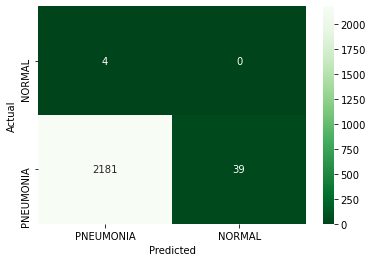

In [21]:
# print(final_base_pred)
tick_labels = ['NORMAL', 'PNEUMONIA']
tick_labels1 = ['PNEUMONIA', 'NORMAL']
actual_label = test_df['label']
#print(classification_report(actual_label, final_base_pred))
matrix=confusion_matrix(actual_label, final_base_pred)
ax =sns.heatmap(matrix,annot=True, fmt='d',cmap="Greens_r")
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.set_xticklabels(tick_labels1)
ax.set_yticklabels(tick_labels)

In [ ]:
def max_deviation(s, max_dev_init=-1):
    occurence = {}

    max_val = 0
    min_val = len(s)
    min_ch = '\0'
    max_dev = max_dev_init

    for i in range(len(s)):
        ch = s[i]
        if ch not in occurence:
            occurence[ch] = 0

        occurence[ch] += 1
        if ch == min_ch:
            min_ch = min(occurence, key=occurence.get)
            min_val = occurence[min_ch]
        elif occurence[ch] < min_val:
            min_val = occurence[ch]
            min_ch = ch

        if occurence[ch] > max_val:
            max_val = occurence[ch]

        # for i in occurence:
        #     if occurence[i] < min_val:
        #         min_val = occurence[i]

        if (max_val - min_val) > max_dev:
            max_dev = max_val - min_val

    if max_dev_init == -1:
        max_dev_inv = max_deviation(s[::-1], max_dev)
        if max_dev_inv > max_dev:
            max_dev = max_dev_inv



    return max_dev


print(max_deviation("aabb"))

In [ ]:
import math
def channelMedian(packets,channelNumbers):
    numberOfPackets=len(packets)//(packets[0])
    #channels = [channelNumbers][numberOfPackets]
    channels = [[0 for x in range(channelNumbers)] for y in range(numberOfPackets)] 
    size1=0
    size2=0
    max1=1
    for i in range (numberOfPackets-2):
        if packets[numberOfPackets-1]==packets[i]:
            max1 +=1
        else:
            break
    index=numberOfPackets-max1
    
    for i in range(numberOfPackets):
        if i==index:
            for j in range(numberOfPackets):
                channels[1][j]=packets[i]
                size2 +=1
                i +=1
                if i==numberOfPackets:
                    break
        else:
            for j in range(numberOfPackets):
                channels[0][js]=packets[i]
                size1 +=1
                i +=1
                if i==index:
                    break
    median1=0
    if size1%2==0:
        mid1=size1/2
        median1=math.ceil((channels[0][mid1-1]+channels[0][mid1])/2)
    else:
        median1=channels[0][size1/2]
    median2=0
    if size2%2==0:
        mid2=size2/2
        median2=math.ceil((channels[1][mid2-1]+channels[1][mid2])/2)
    else:
         median2=channels[1][size2/2]
    
    median=median1+median2
    
    return median


packets =[1,2,3,4,5]
channels=2

print(channelMedian(packets,channels))
    
    
            
    
    